In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os 

from tqdm import tqdm_notebook

import cv2

In [2]:
path = "../data/stage_1_fixes/stage1_train/"
names = os.listdir(path)

In [3]:
def mirror(im, mask):
    shape = im.shape
    h = lambda arr: np.hstack((arr[:,(shape[1] // 2)::-1], arr, arr[:,:(shape[1] // 2):-1]))
    v = lambda arr: np.vstack((arr[shape[0] // 2::-1,:], arr, arr[:shape[0] // 2:-1,:]))

    return v(h(im)), v(h(mask))

In [4]:
def show(im, i = None, figsize =None):
    if len(im.shape) == 3:
        to_show = im[:,:,i]
    else:
        to_show = im
        
    if not figsize is None:
        plt.figure(figsize=(figsize))
    plt.imshow(to_show, cmap='gray')
    plt.colorbar()
    plt.show()
    

In [5]:
len(names)

664

In [312]:
im = cv2.imread("../data/extra_data/TCGA-18-5592-01Z-00-DX1/images/TCGA-18-5592-01Z-00-DX1.tif")

In [41]:
train_names = names[:620]
val_names = names[620:]

In [326]:
ext_path = "../data/extra_data/"
ext_names = sorted(os.listdir(ext_path))

In [327]:
name = names[0]

In [328]:
ext_names

['TCGA-18-5592-01Z-00-DX1',
 'TCGA-21-5784-01Z-00-DX1',
 'TCGA-21-5786-01Z-00-DX1',
 'TCGA-38-6178-01Z-00-DX1',
 'TCGA-49-4488-01Z-00-DX1',
 'TCGA-50-5931-01Z-00-DX1',
 'TCGA-A7-A13E-01Z-00-DX1',
 'TCGA-A7-A13F-01Z-00-DX1',
 'TCGA-AR-A1AK-01Z-00-DX1',
 'TCGA-AR-A1AS-01Z-00-DX1',
 'TCGA-AY-A8YK-01A-01-TS1',
 'TCGA-B0-5698-01Z-00-DX1',
 'TCGA-B0-5710-01Z-00-DX1',
 'TCGA-B0-5711-01Z-00-DX1',
 'TCGA-CH-5767-01Z-00-DX1',
 'TCGA-DK-A2I6-01A-01-TS1',
 'TCGA-E2-A14V-01Z-00-DX1',
 'TCGA-E2-A1B5-01Z-00-DX1',
 'TCGA-G2-A2EK-01A-02-TSB',
 'TCGA-G9-6336-01Z-00-DX1',
 'TCGA-G9-6348-01Z-00-DX1',
 'TCGA-G9-6356-01Z-00-DX1',
 'TCGA-G9-6362-01Z-00-DX1',
 'TCGA-G9-6363-01Z-00-DX1',
 'TCGA-HE-7128-01Z-00-DX1',
 'TCGA-HE-7129-01Z-00-DX1',
 'TCGA-HE-7130-01Z-00-DX1',
 'TCGA-KB-A93J-01A-01-TS1',
 'TCGA-NH-A8F7-01A-01-TS1',
 'TCGA-RD-A8N9-01A-01-TS1']

In [43]:
DEFAULT_VERTICAL = 512

In [385]:
def process_data(names, path, engine = 'plt', prefix = '', cut = False, use_padding = False, resize = False, store = False):
    im_w_mask_list = []
    
    for name in tqdm_notebook(names):
        if engine == 'plt':
            im = plt.imread(path + name + "/images/" + name + ".png")[:,:,:3]
        else:
            im = cv2.imread(path + name + "/images/" + name + ".tif")[:,:,:3]

        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        masks_path = path + name + "/masks/"
        masks_names = os.listdir(masks_path)

#         mask = np.zeros_like(im[:,:,0])
#         for m_name in masks_names:
#             mask += plt.imread(masks_path + m_name)

        mask = None
        for m_name in masks_names:
            if mask is None:
                mask = cv2.morphologyEx(plt.imread(masks_path + m_name), cv2.MORPH_ERODE, np.ones((2,2)))
                #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((2,2)))
                countour = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, np.ones((2,2)))
            else:
                curr =  plt.imread(masks_path + m_name)
                curr =  cv2.morphologyEx(curr, cv2.MORPH_ERODE, np.ones((2,2)))
                #print(label(curr).max())
                mask += curr
                countour += cv2.morphologyEx(curr, cv2.MORPH_GRADIENT, np.ones((2,2)))

        if resize:
            im = cv2.resize(im, (DEFAULT_VERTICAL, int(im.shape[1] * resize_ratio)))
            mask = cv2.resize(mask, (DEFAULT_VERTICAL, int(mask.shape[1] * resize_ratio)))
        
        if use_padding:
            im,mask = mirror(im, mask)
        
        im_w_mask = (np.stack((im, (mask >= 1).astype(int), (countour >= 1).astype(int)), 2))
        
        
        #print(im_w_mask.shape)

        if cut:
            x_linspace = np.linspace(0, im.shape[0], 5)
            y_linspace = np.linspace(0, im.shape[1], 5)
            
            for xl,xh in zip(x_linspace,x_linspace[2:]):
                for yl,yh in zip(y_linspace,y_linspace[2:]):
                    xl,xh,yl,yh = int(xl),int(xh),int(yl),int(yh)

                    #np.save("../data/ext_proc/" + name + str(xl) + "_" + str(yl), im_w_mask[xl:xh,yl:yh])
            
                    if store:
                        im_w_mask_list.append(im_w_mask[xl:xh,yl:yh])
                    
        #masks.append(mask)
        
        
    
    return im_w_mask_list


In [386]:
im_w_mask_list = process_data(sorted(ext_names)[-4:-3], ext_path, 'cv2',cut=True, store=True)

A Jupyter Widget

In [389]:
im_w_mask_list[0][0].max()

235

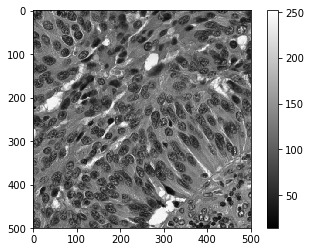

In [387]:
show(im_w_mask_list[0],0)

In [373]:
im= im_w_mask_list[0]

In [6]:
def get_bublick(s1,s2):
    big = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(s1,s1)) +cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(s1,s1)).T
    small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(s2,s2)) +cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(s2,s2)).T
    big[(s1-s2)//2:(s1+s2)//2,(s1-s2)//2:(s1+s2)//2] -= small
    return big / big.sum()

def get_weights(im):
    weights = np.zeros_like(im[:,:,0])
    
    ones = im[:,:,1].sum()
    zeros = im.shape[0] * im.shape[1] - ones

    weights[im[:,:,1] > 0] = zeros / (im.shape[0] * im.shape[1])
    weights[im[:,:,1] == 0] = ones / (im.shape[0] * im.shape[1])
    
    kernel = get_bublick(11,5)
    dists = cv2.filter2D(im[:,:,1], -1, kernel)
    dists = (np.exp(np.stack((dists - im[:,:,1], np.zeros_like(dists))).max(0) ** 3) - 1) * 5
    return weights, dists

In [246]:
im = im_w_mask_list[0]

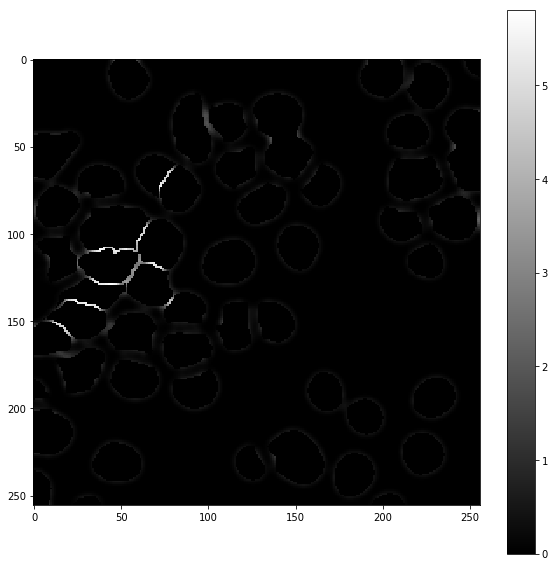

In [247]:
show(get_weights(im)[1], figsize=(10,10))

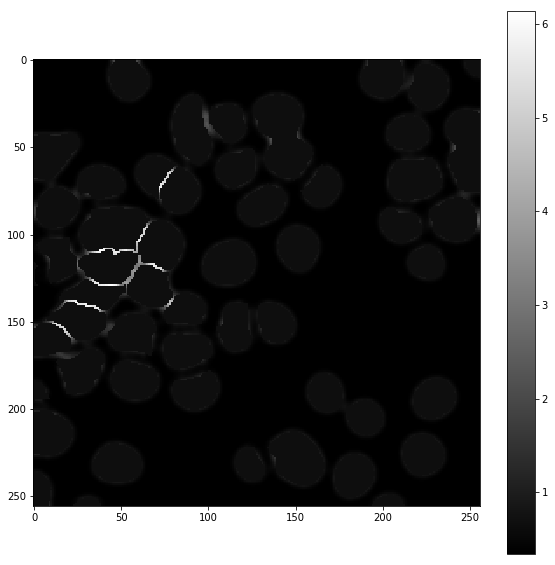

In [248]:
show(get_weights(im)[1] + get_weights(im)[0], figsize=(10,10))

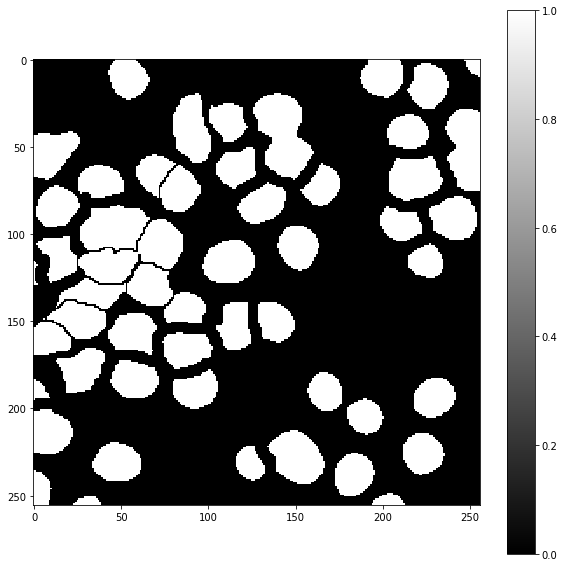

In [216]:
show(im, 1, figsize=(10,10))

In [224]:
name

'2f929b067a59f88530b6bfa6f6889bc3a38adf88d594895973d1c8b2549fd93d'

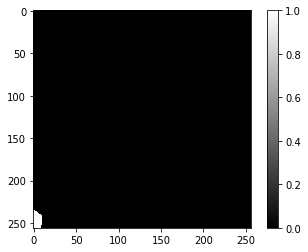

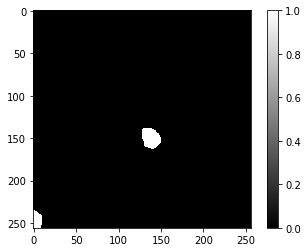

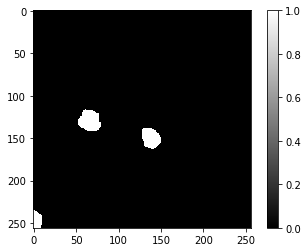

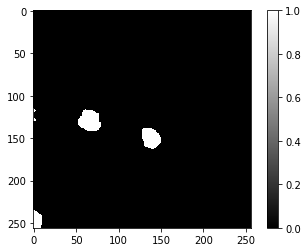

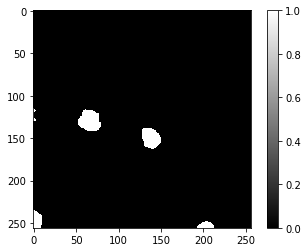

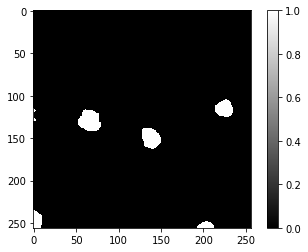

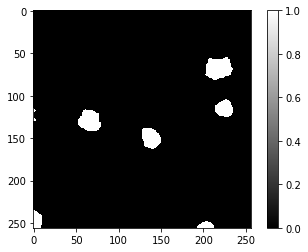

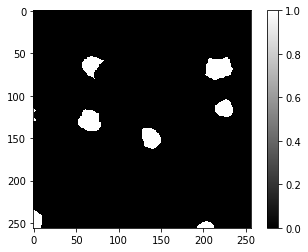

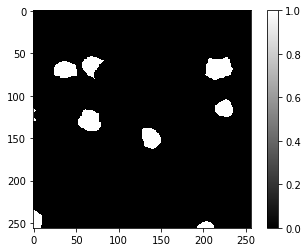

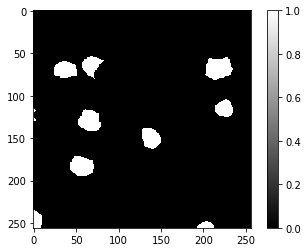

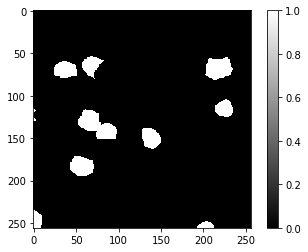

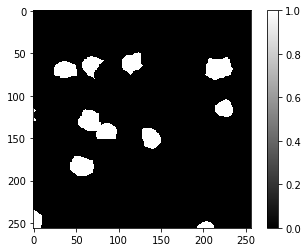

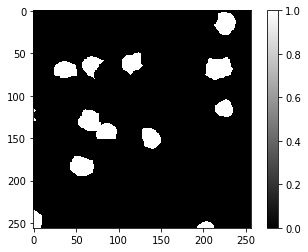

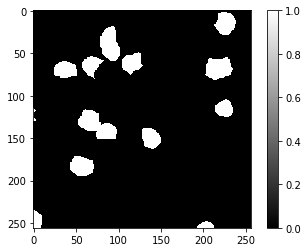

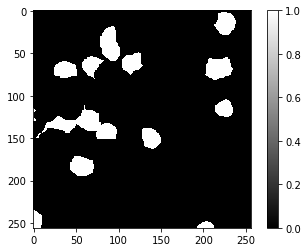

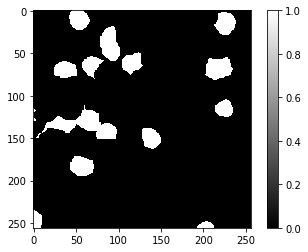

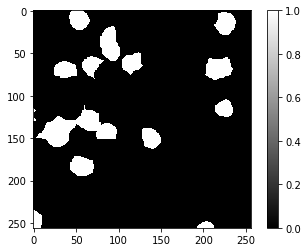

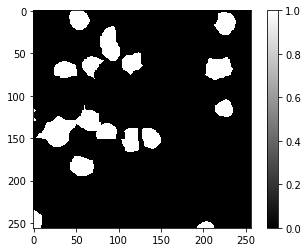

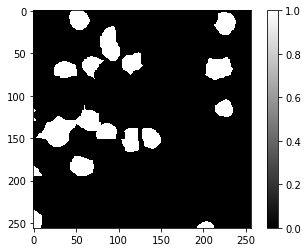

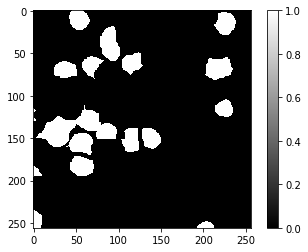

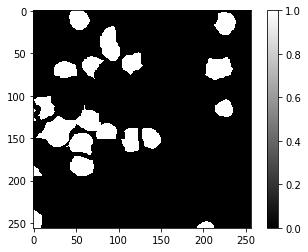

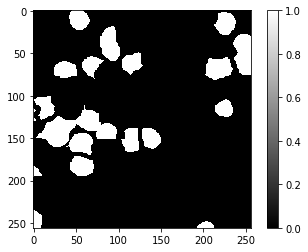

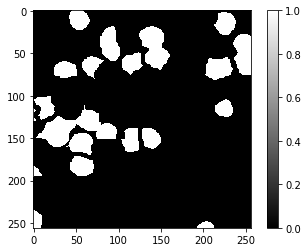

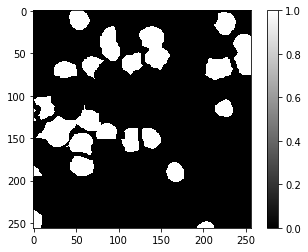

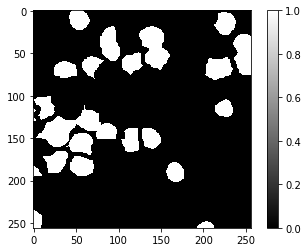

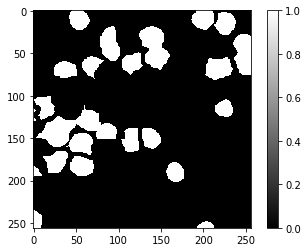

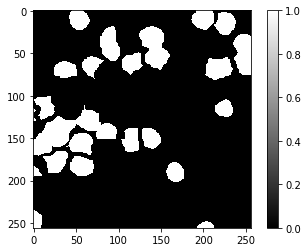

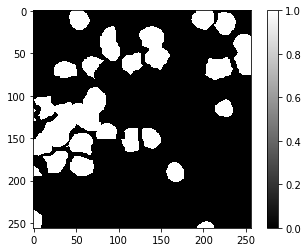

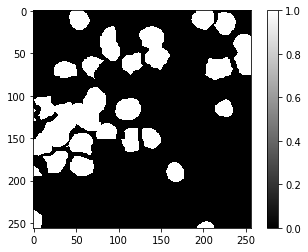

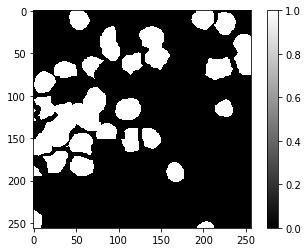

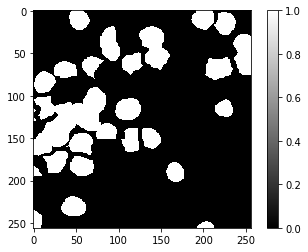

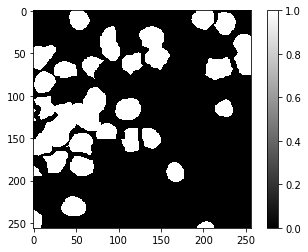

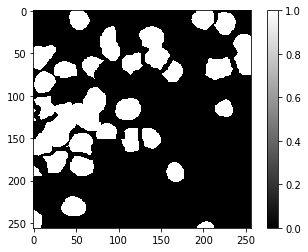

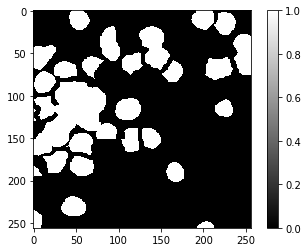

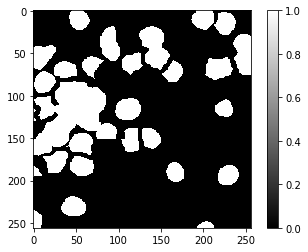

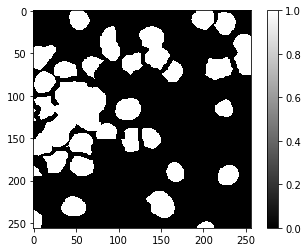

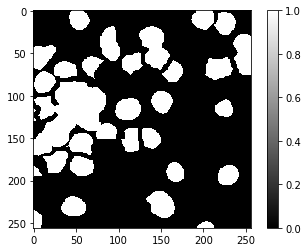

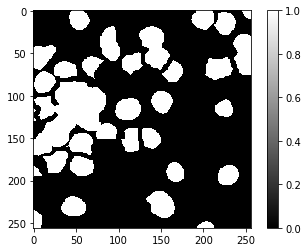

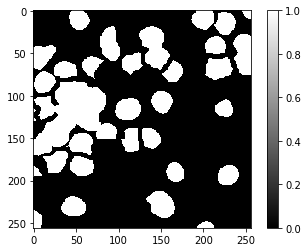

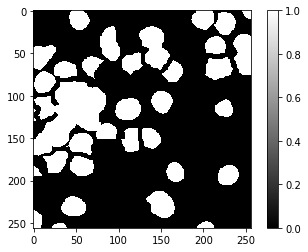

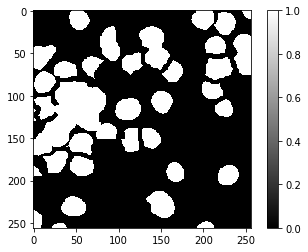

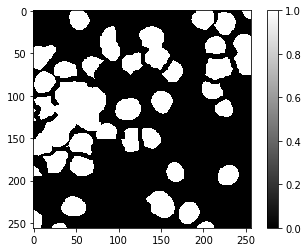

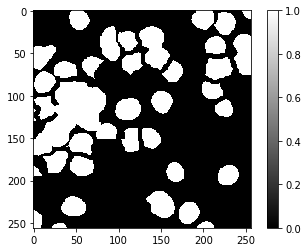

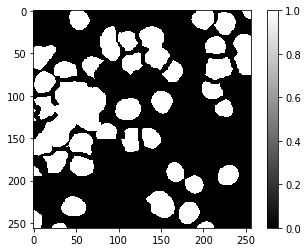

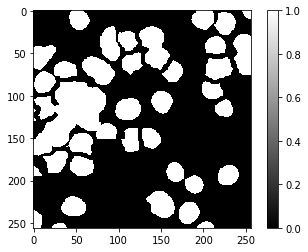

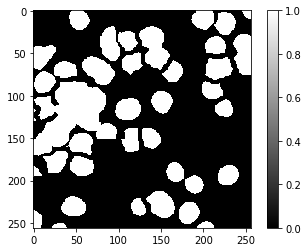

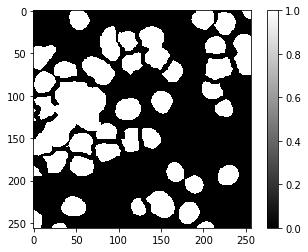

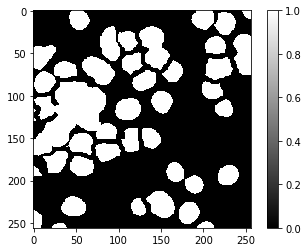

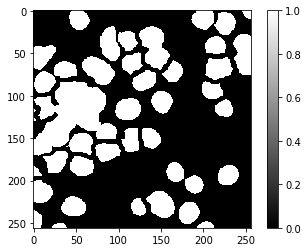

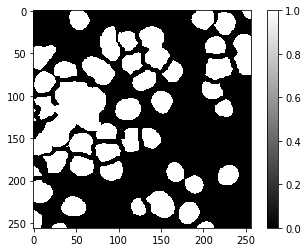

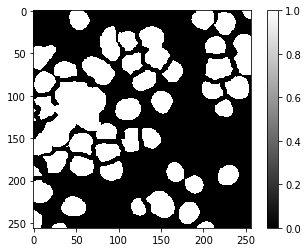

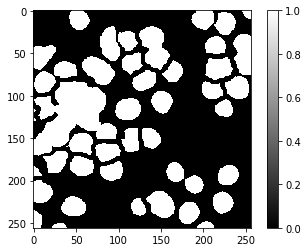

52
52
44


In [223]:
name = sorted(names[20:30])[0]
masks_path = path + name + "/masks/"
masks_names = os.listdir(masks_path)

mask = None
countour = None
mn = 0
for m_name in masks_names:
    if mask is None:
        mask = plt.imread(masks_path + m_name)
        #mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((2,2)))
        countour = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, np.ones((2,2)))
        mn += label(mask).max()
    else:
        curr =  plt.imread(masks_path + m_name)
        #curr =  cv2.morphologyEx(curr, cv2.MORPH_OPEN, np.ones((2,2)))
        mn += label(curr).max()
        #print(label(curr).max())
        mask += curr
        countour += cv2.morphologyEx(curr, cv2.MORPH_GRADIENT, np.ones((2,2)))
    show(mask)
        
        
print(len(masks_names))
print(mn)
print(label(mask).max())

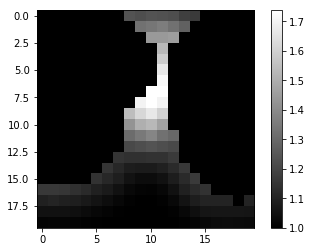

In [192]:
show(np.exp(dists ** 2)[200:220, 50:70])

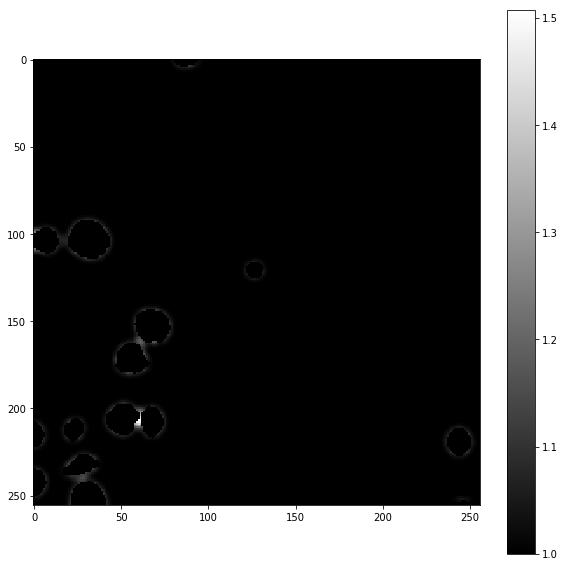

In [195]:
show(np.exp(dists ** 3),figsize=(10,10))

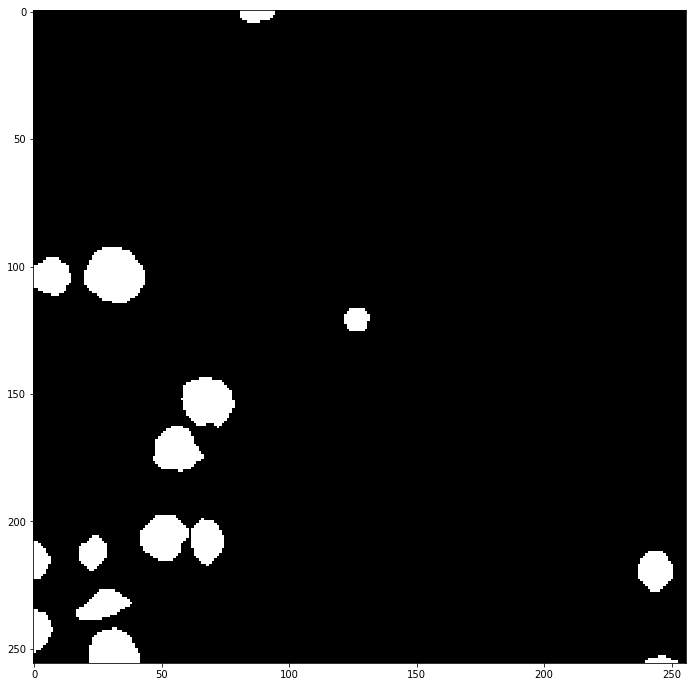

In [123]:
show(im, 1, figsize=(12,12))

In [ ]:
def nearest_1(im, point):
    radius = 0
    found = False
    while not found:
        

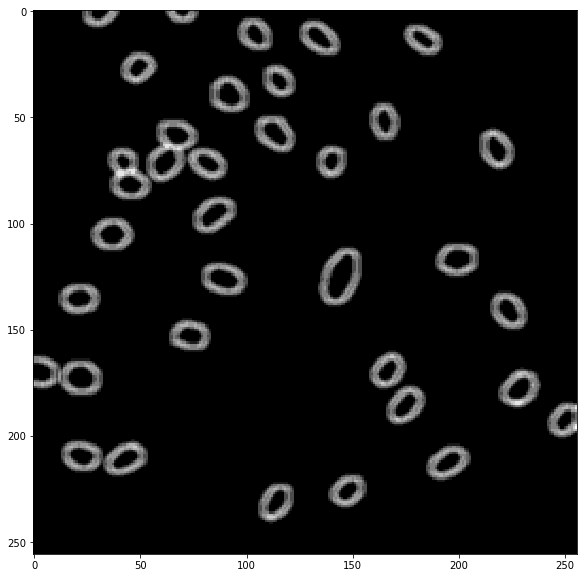

In [339]:
circle5=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
show(cv2.filter2D(im,-1,circle5), figsize =(10,10))

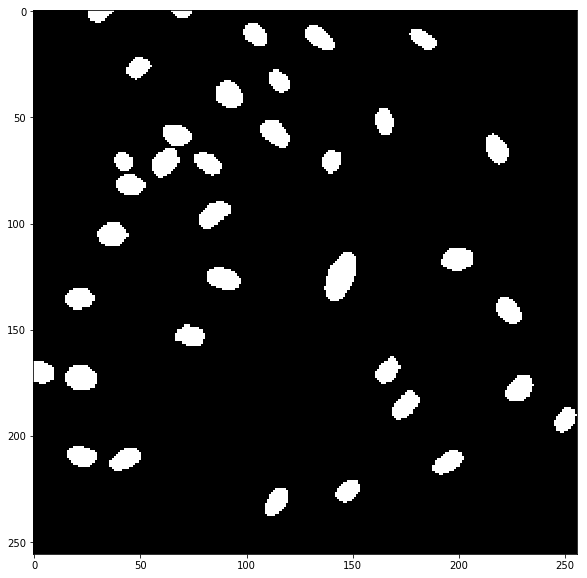

In [330]:
show((im_w_mask_list[1][:,:,1] - im_w_mask_list[1][:,:,2] )> 0, figsize=(10,10))

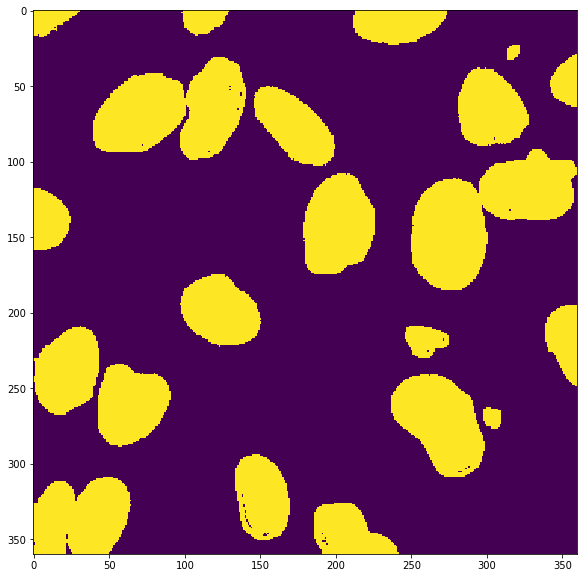

In [41]:
plt.figure(figsize = (10,10))
plt.imshow(np.load("../data/stage_1_processed/train/train_0532c64c2fd0c4d3188cc751cdfd566b1cfba3d269358717295bab1504c7c275.npy")[:,:,1])
plt.show()

In [22]:
test_data = np.load("../data/stage_1_processed/val/val_08151b19806eebd58e5acec7e138dbfbb1761f41a1ab9620466584ecc7d5fada.npy")

In [24]:
test_data[:,:,0]

array([[ 6,  6,  6, ..., 24, 23, 24],
       [ 5,  6,  6, ..., 24, 23, 23],
       [ 6,  7,  7, ..., 23, 22, 23],
       ...,
       [32, 35, 32, ...,  6,  7,  7],
       [34, 35, 33, ...,  6,  6,  7],
       [35, 36, 34, ...,  7,  7,  7]], dtype=uint8)

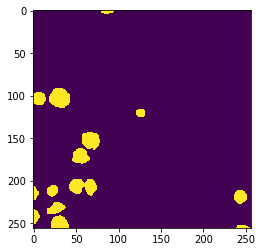

In [17]:
plt.imshow(im_w_mask_list[0][:,:, 1])
plt.show()

## Check original masks

In [5]:
path = "../data/stage_1_fixes/stage1_train/"
names = os.listdir(path)

In [8]:
name = names[0]
name

'e321cfa987e77c21373a0f8b1236c83d6636306949a82a7f5b07fc0838e7777f'

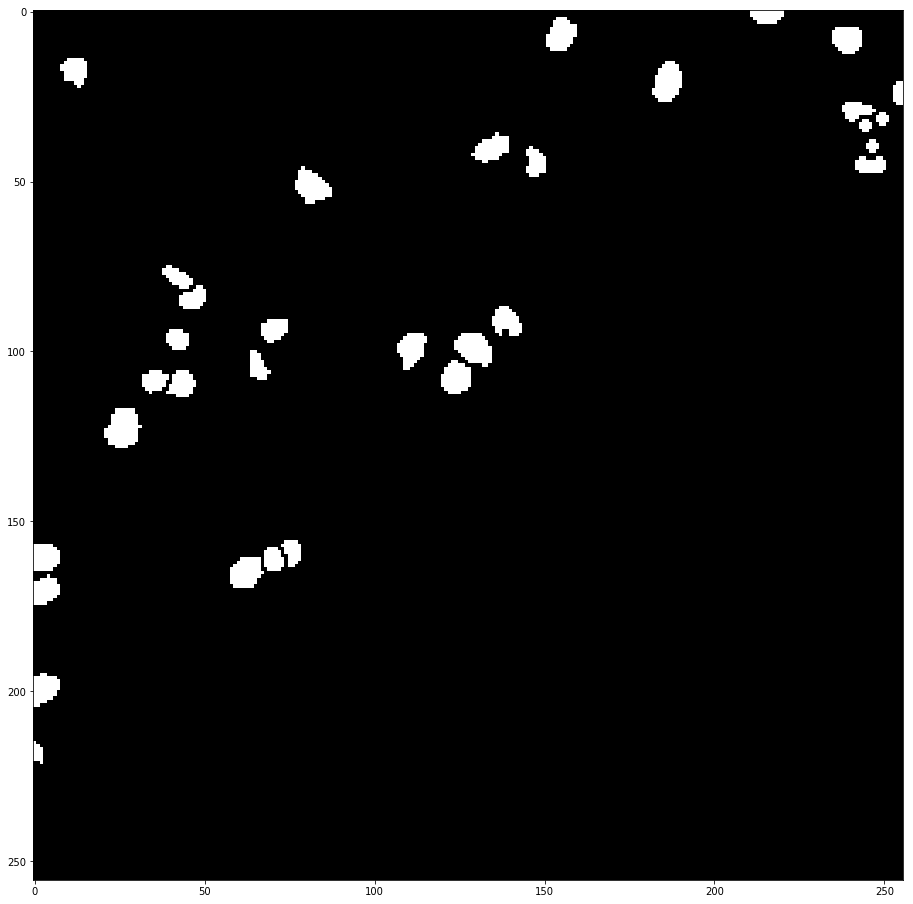

In [282]:
show(np.logical_and((mask >= 1), np.logical_not(countour >= 1)), figsize=(16,16))

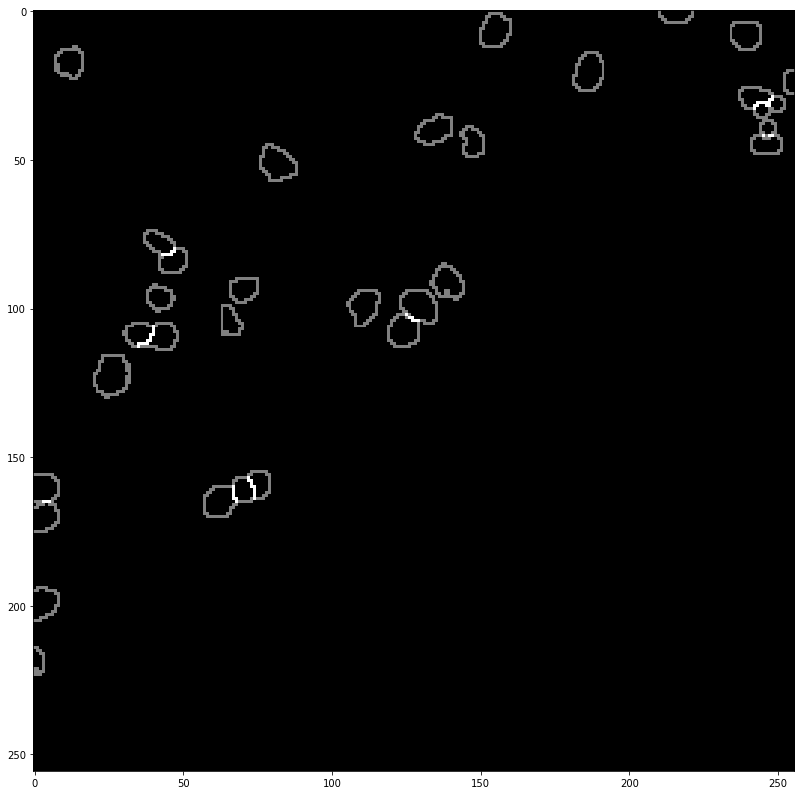

In [283]:
show(countour, figsize=(14,14))

In [288]:
m = np.load("../data/stage_1_processed/train/train_"+name+".npy")

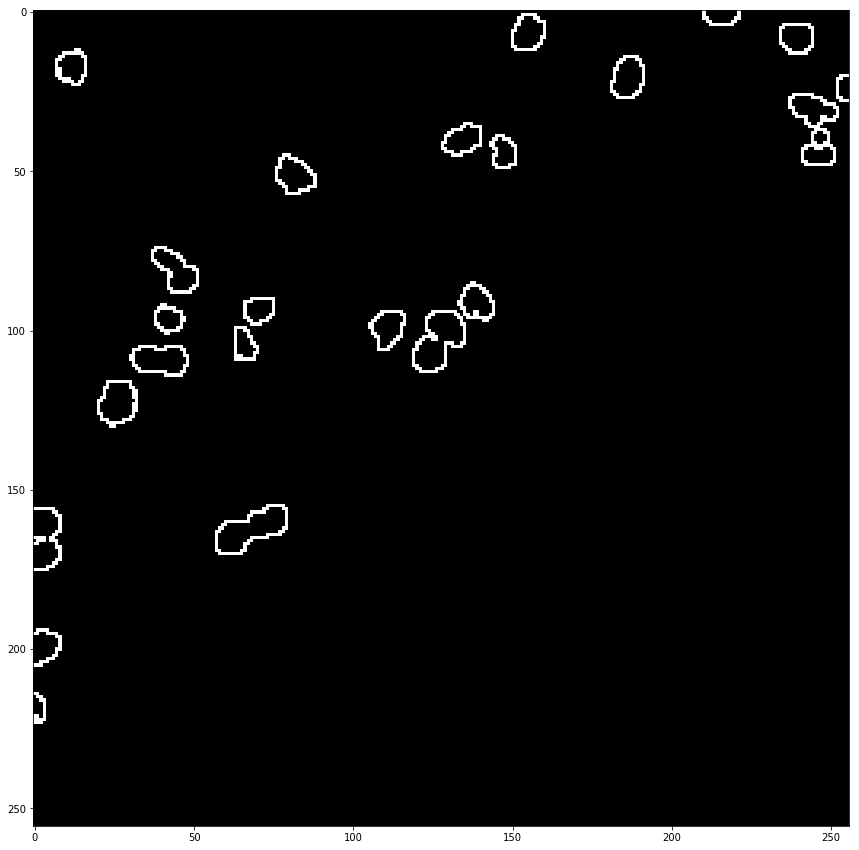

In [290]:
show(m[:,:,2], figsize=(15,15))

In [266]:
countour.max()

2.0

## Reverse RLE

In [7]:
from skimage.morphology import label

In [8]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [9]:
def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [10]:
def reverse_RLE(mask, shape):
    im = np.zeros(shape[0] * shape[1])
    if type(mask) == str:
        mask = mask.split(" ")
    posns = np.array([int(x) for x in mask]).reshape(-1,2)
    
    for p in posns:
        im[p[0] - 1 :p[0] - 1 + p[1]] = 1
    
    return im.reshape(shape[::-1]).T.astype(int)

In [45]:
a = np.zeros((4,5)).astype(int)
a[1,1] = 1
a[1,2] = 1
a[2,1] = 1
a[1,3] =1
a[0,3] = 1
a

array([[0, 0, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [46]:
reverse_RLE([x for x in prob_to_rles(a)][0], a.shape)

[[ 6  2]
 [10  1]
 [13  2]]


array([[0, 0, 0, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0]])

## check my predictions vs original

In [11]:
import pandas as pd

In [53]:
true_masks = pd.read_csv("../data/stage1_solution.csv")
flip_masks = pd.read_csv("../data/flip_predict_05.csv")
#random_masks = pd.read_csv("../data/random_predict_05_2.csv")
cool_masks = pd.read_csv("../data/wce_pred_06_5.csv")

In [35]:
ids = set(cool_masks.ImageId.values)

In [36]:
ids_list=[x for x in ids]

In [41]:
im_id = ids_list[1]

In [42]:
def restore_mask(im_id, shape, masks_table):
    id_mask = masks_table.ImageId == im_id
    
    print(masks_table[id_mask].shape[0])
    mask = np.zeros(shape)
    for row in masks_table[id_mask].iterrows():
        mask += reverse_RLE(row[1].EncodedPixels,shape)
        
    return mask

In [43]:
print(im_id)
ids_mask = true_masks.ImageId.values == im_id
true_masks[ids_mask].head(1)


0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925


,ImageId,EncodedPixels,Height,Width,Usage
116,0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd4...,9516 5 9767 13 10022 14 10276 18 10531 20 1078...,256,256,Public


10


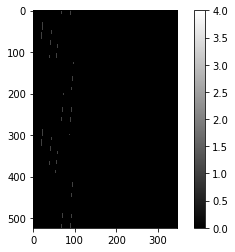

In [44]:
show(restore_mask(im_id, [524, 348], cool_masks) )

In [54]:
#prec_1 = []

flip_p=np.zeros(len(ids_list))
random_p=np.zeros(len(ids_list))
cool_p=np.zeros(len(ids_list))

A Jupyter Widget

134
58
92


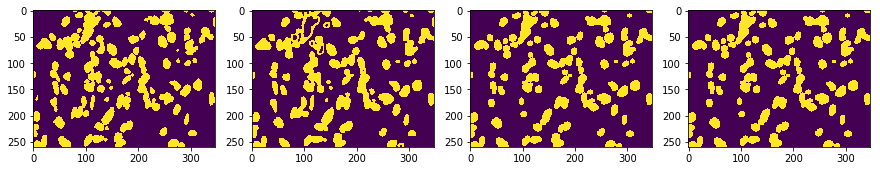

9
10
11


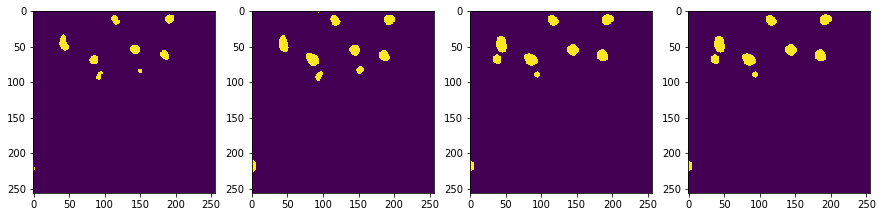

219
83
162


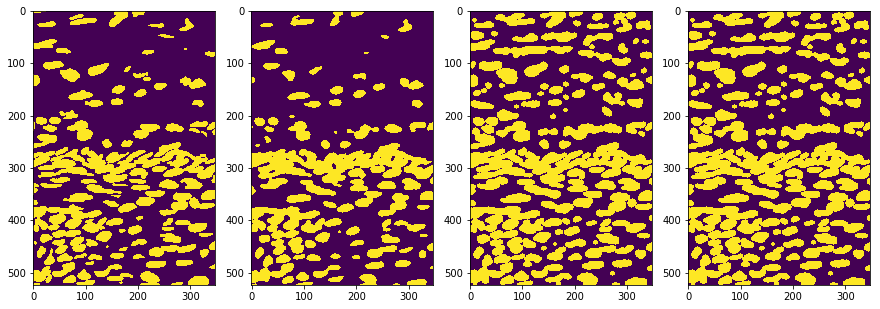

71
43
419


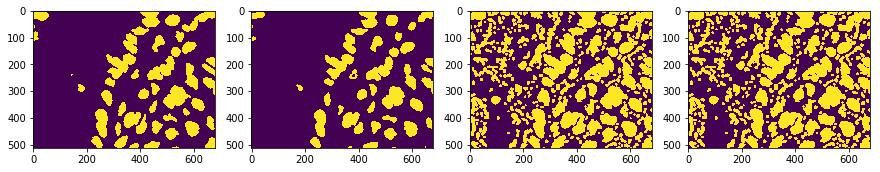

205
96
158


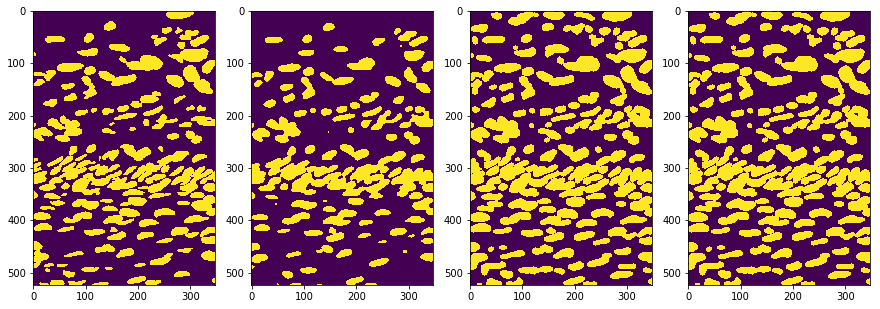

16
14
17


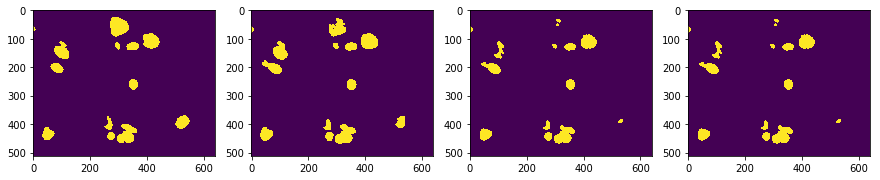

28
21
22


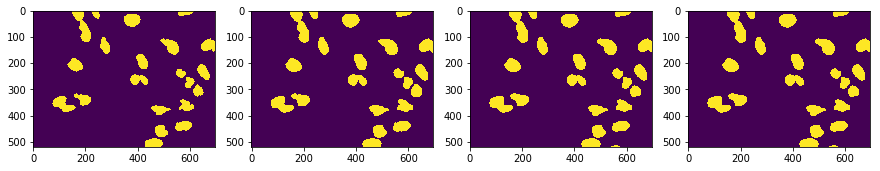

75
35
42


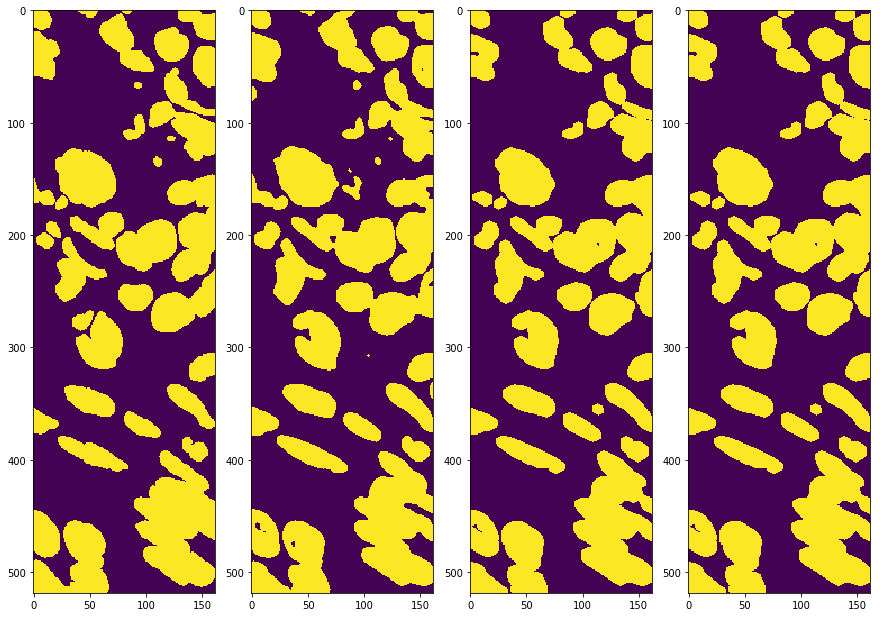

34
30
33


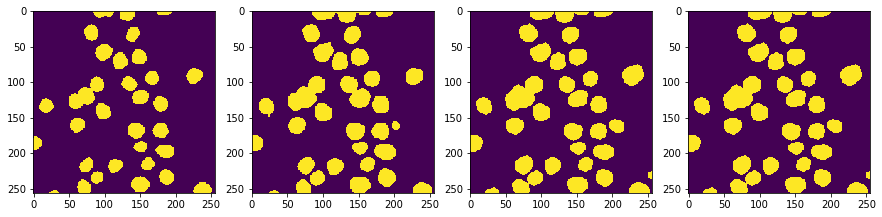

30
23
25


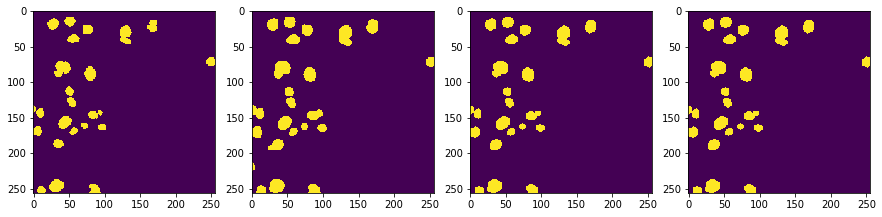

9
10
9


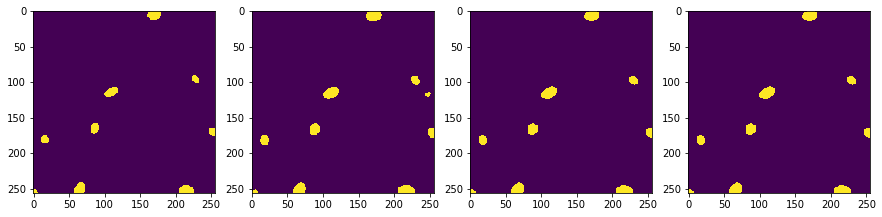

60
34
46


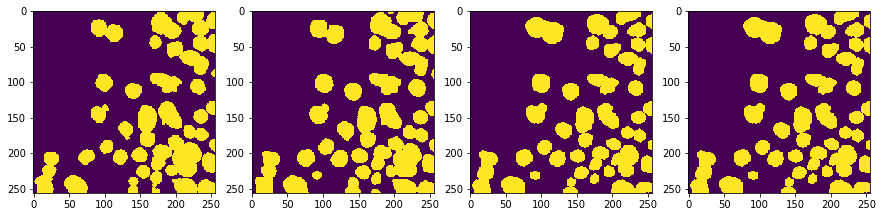

13
13
13


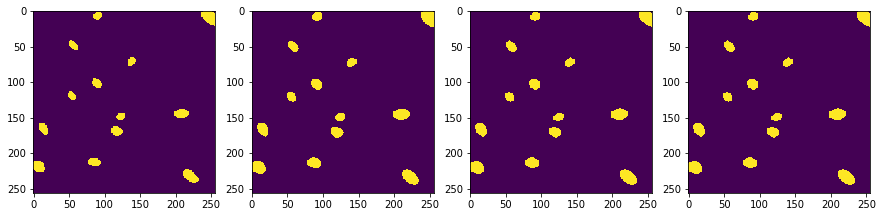

31
13
223


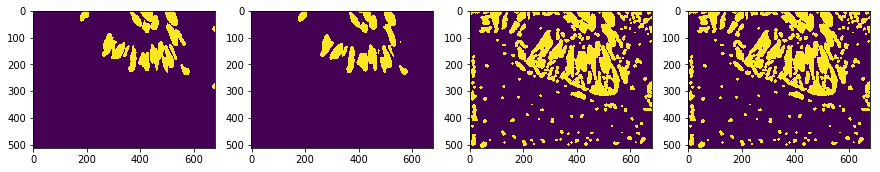

59
52
55


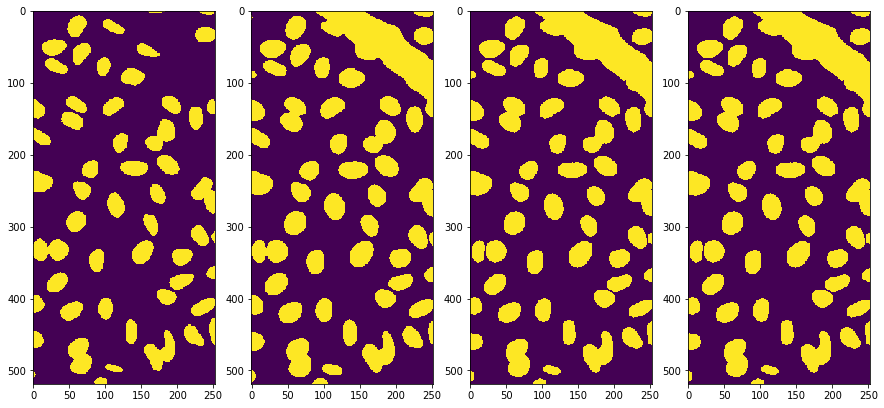

45
32
44


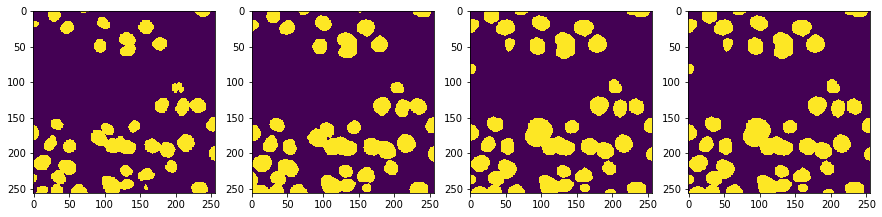

264
107
158


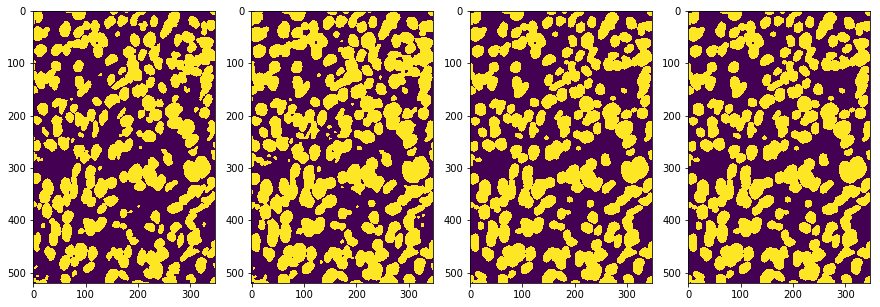

98
6
55


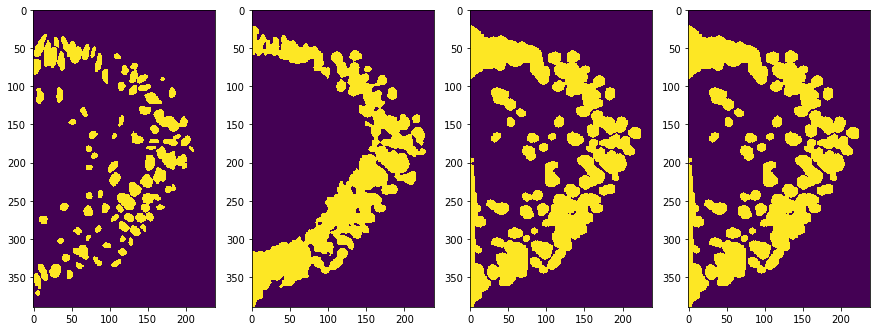

129
69
89


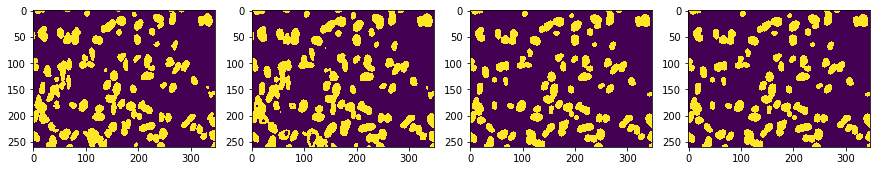

91
81
69


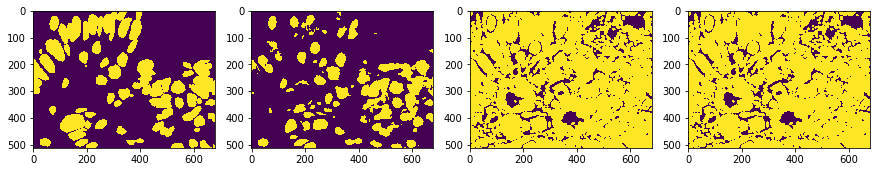

22
17
66


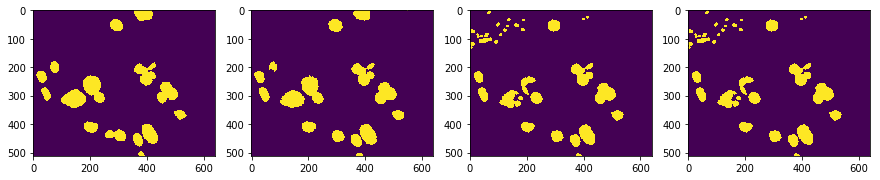

81
42
48


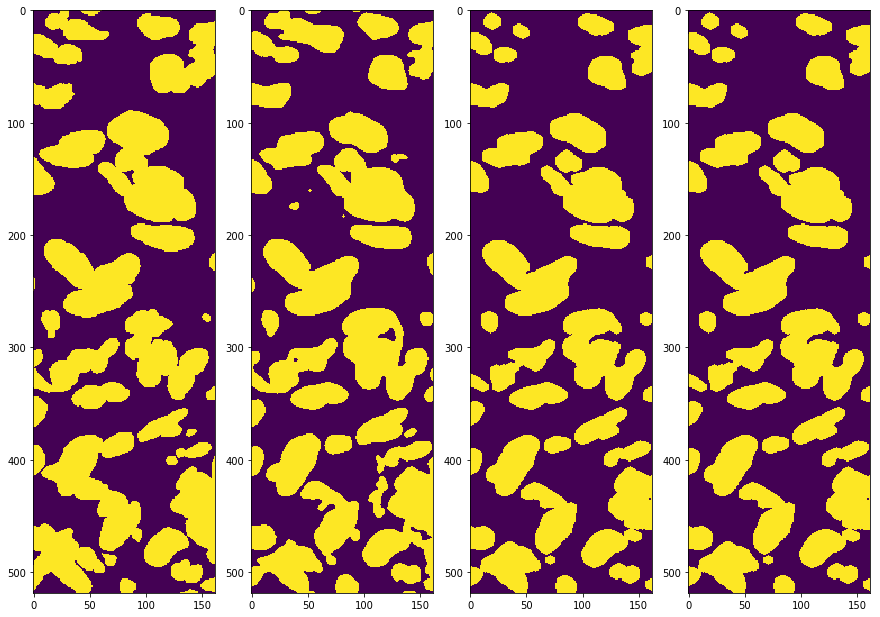

88
46
75


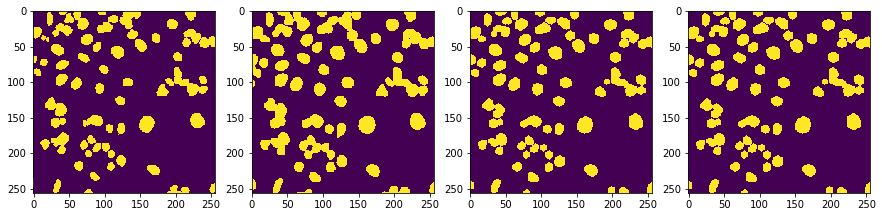

78
47
65


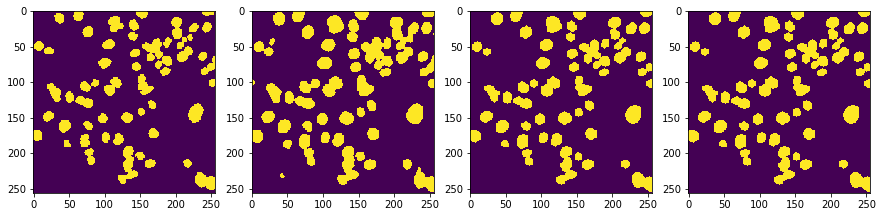

5
6
7


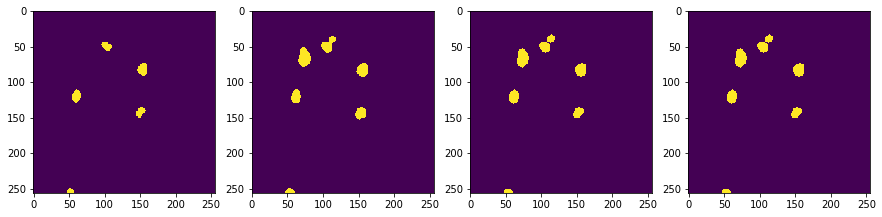

66
43
53


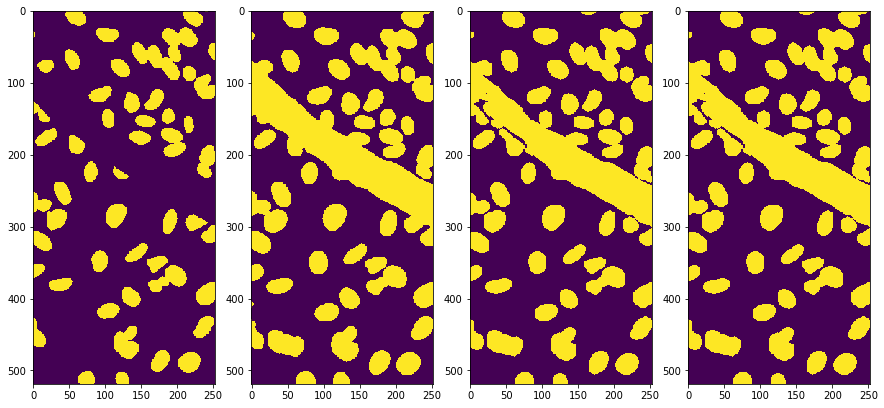

115
77
176


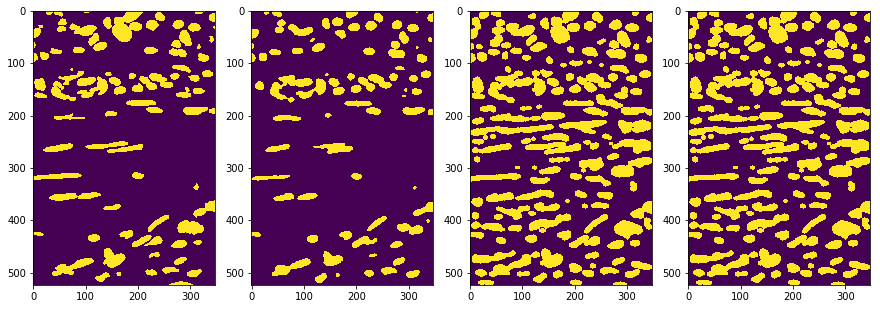

9
10
9


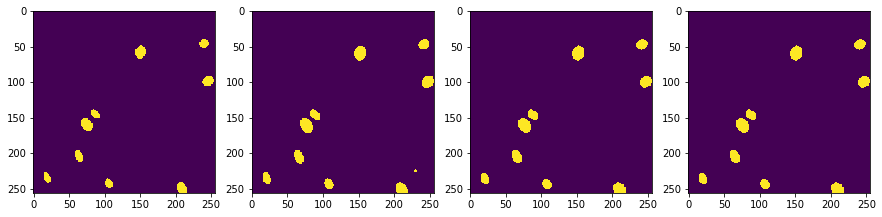

30
18
18


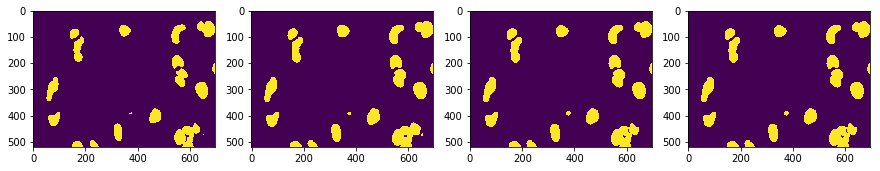

311
107
166


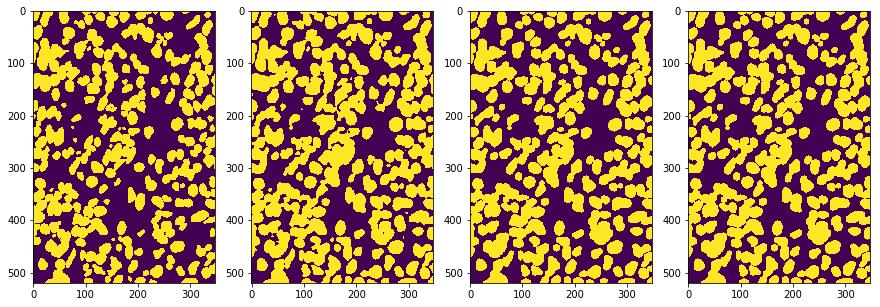

6
4
6


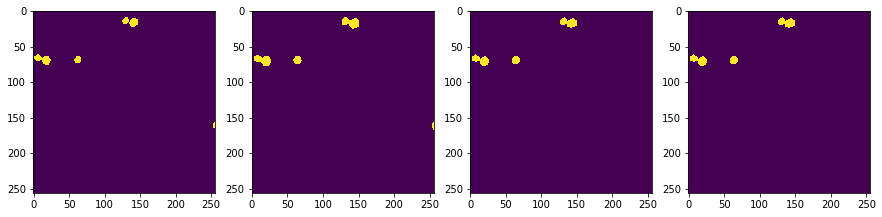

10
11
12


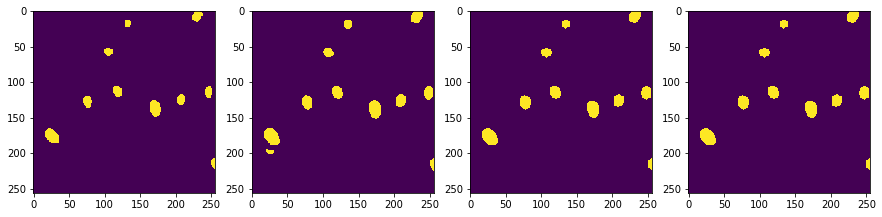

70
68
86


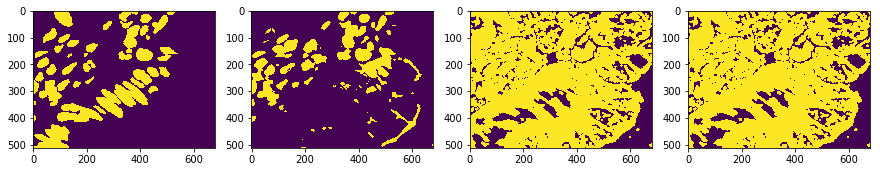

329
116
190


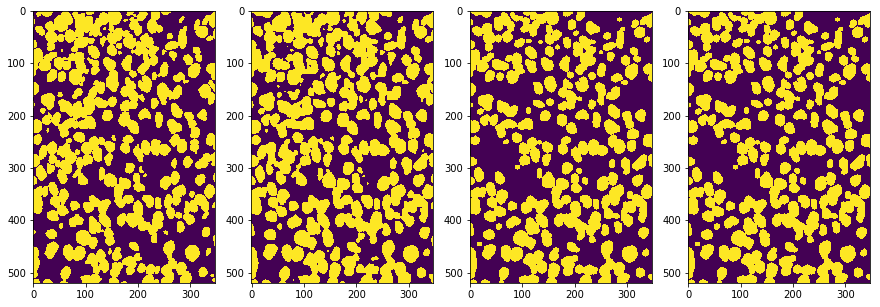

4
11
12


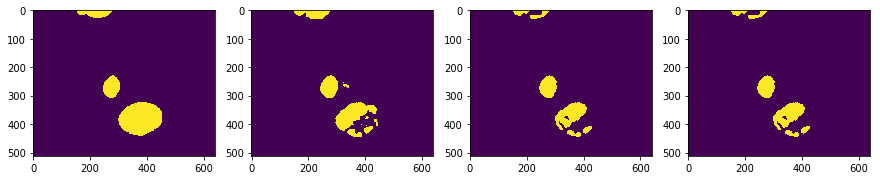

14
6
10


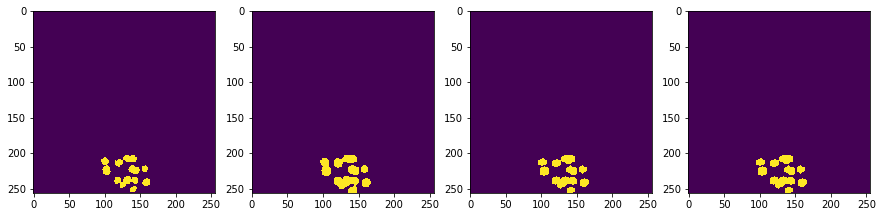

73
28
44


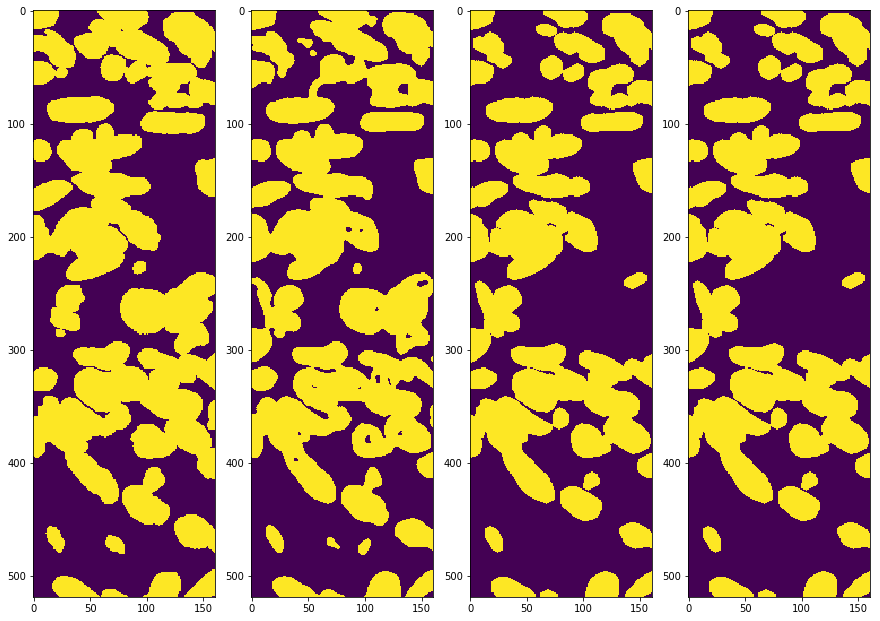

9
7
9


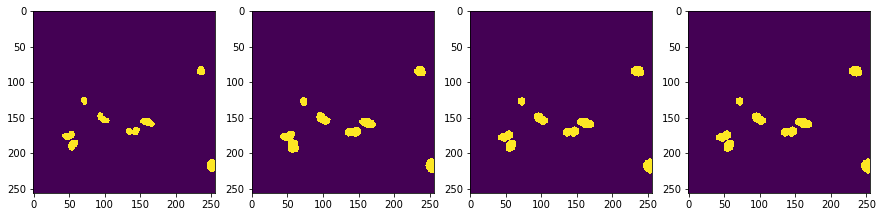

44
29
291


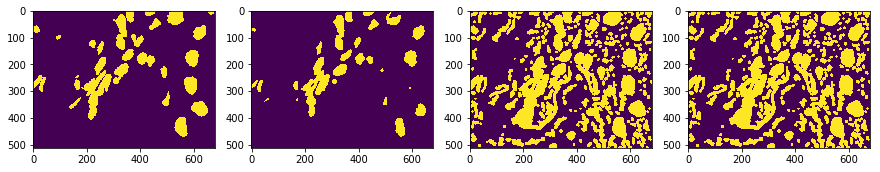

3
10
18


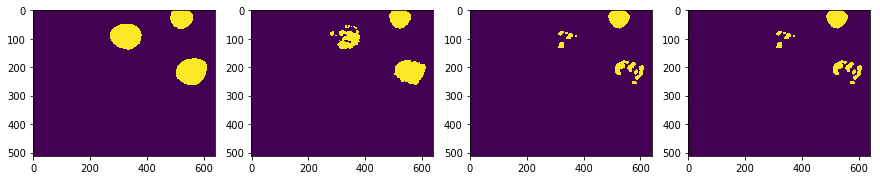

3
5
5


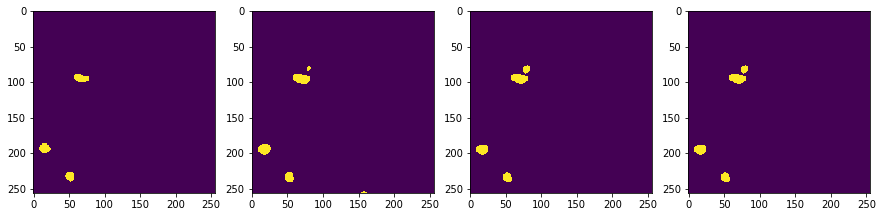

34
17
22


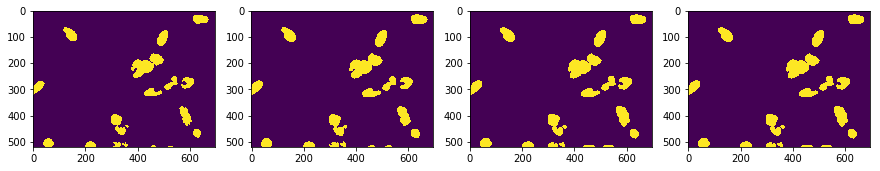

146
60
90


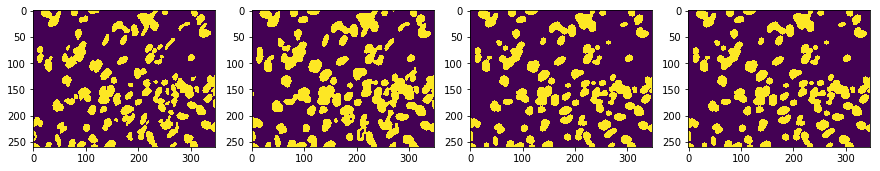

7
5
6


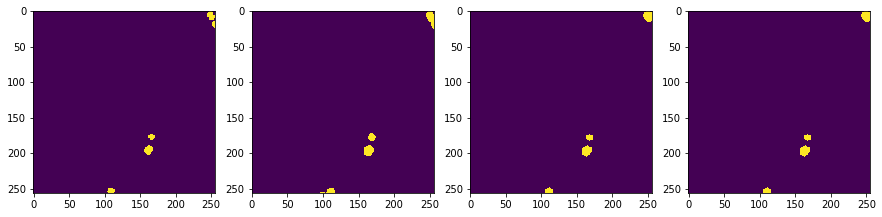

4
11
15


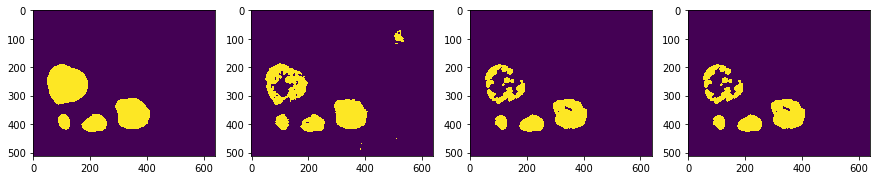

15
16
61


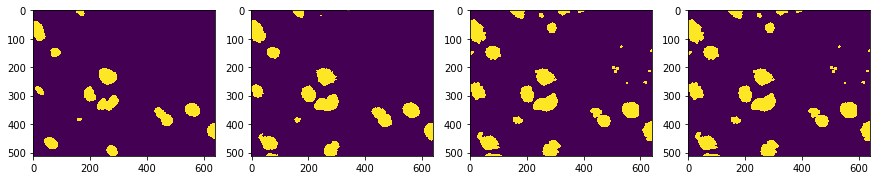

249
112
162


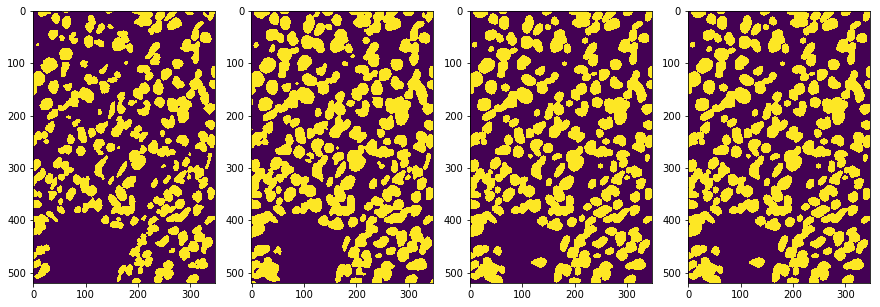

10
12
11


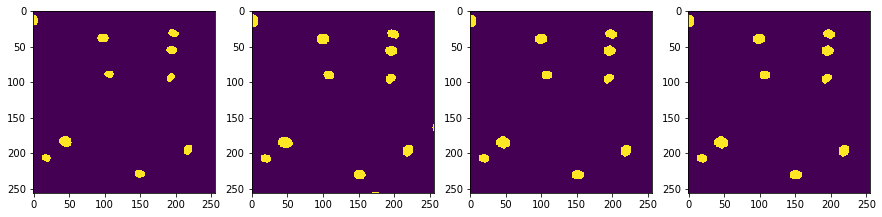

23
24
128


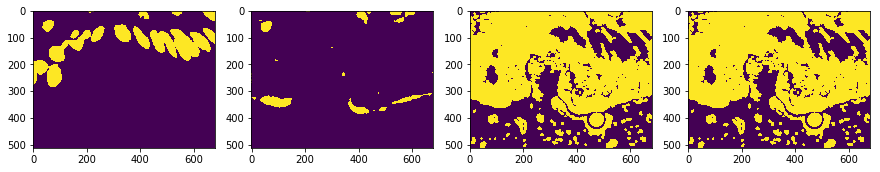

60
35
40


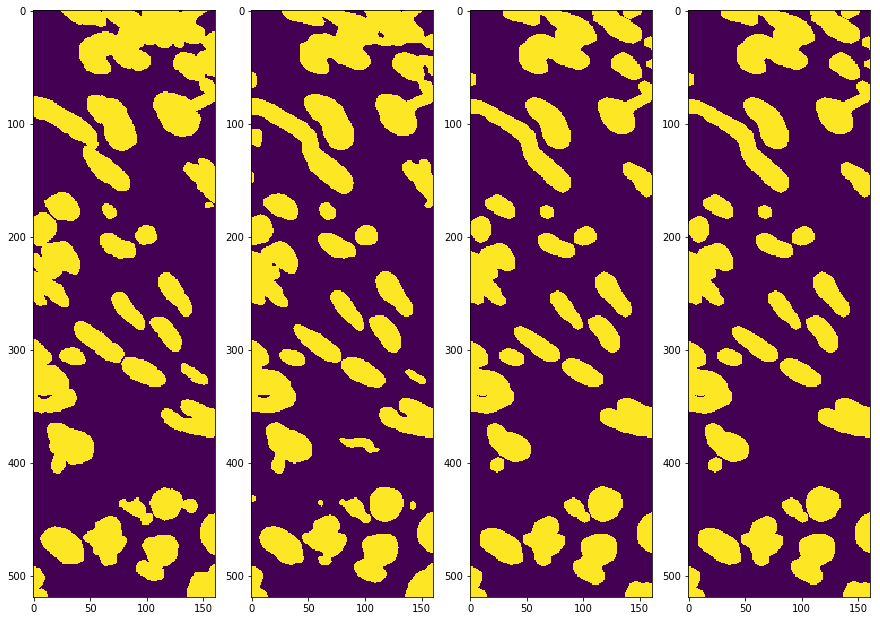

91
50
370


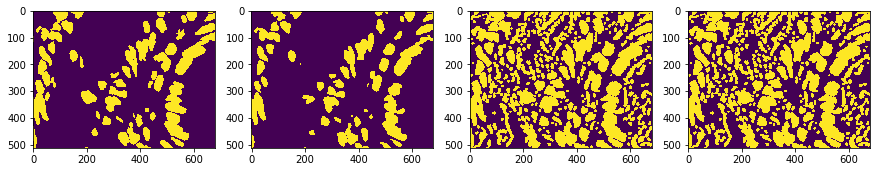

21
9
12


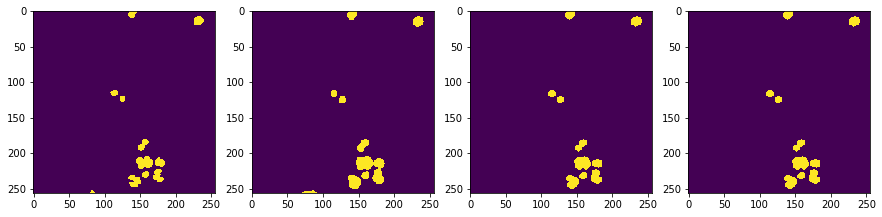

55
44
52


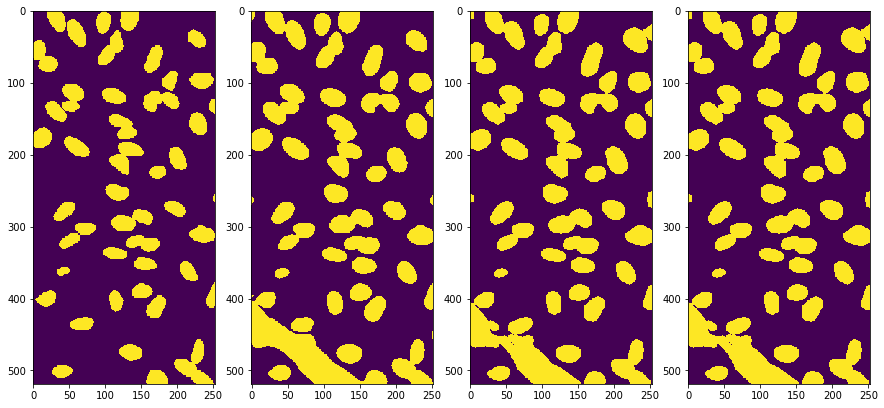

6
8
8


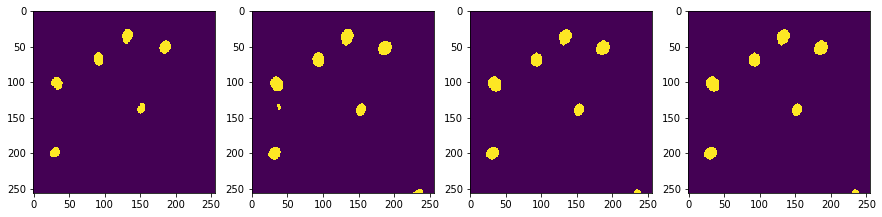

97
62
69


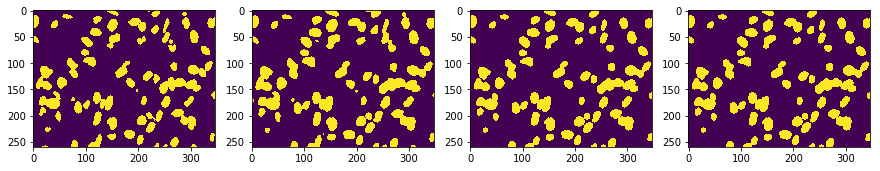

38
26
30


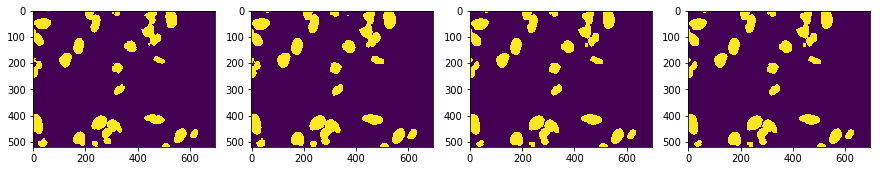

32
18
27


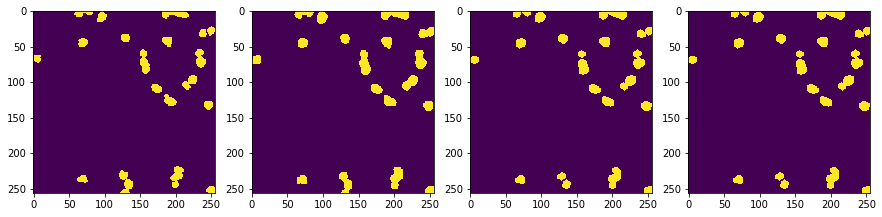

7
6
7


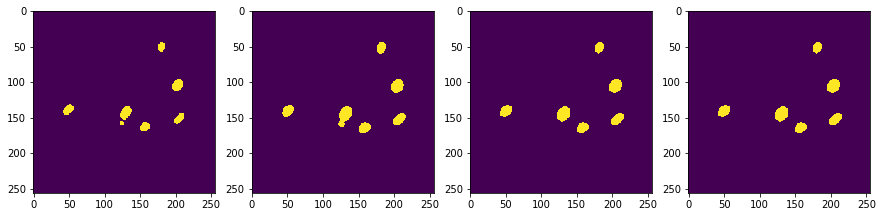

98
69
177


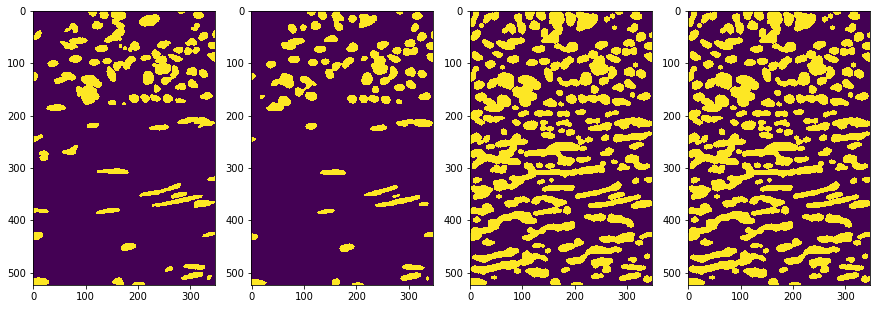

50
34
38


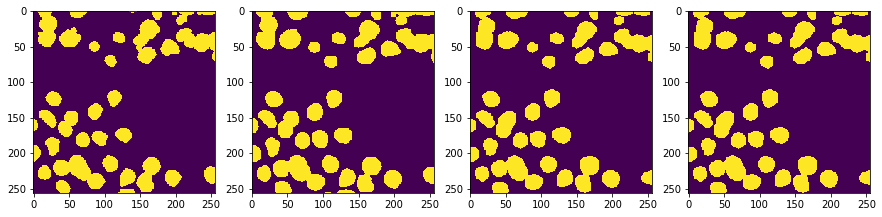

58
45
52


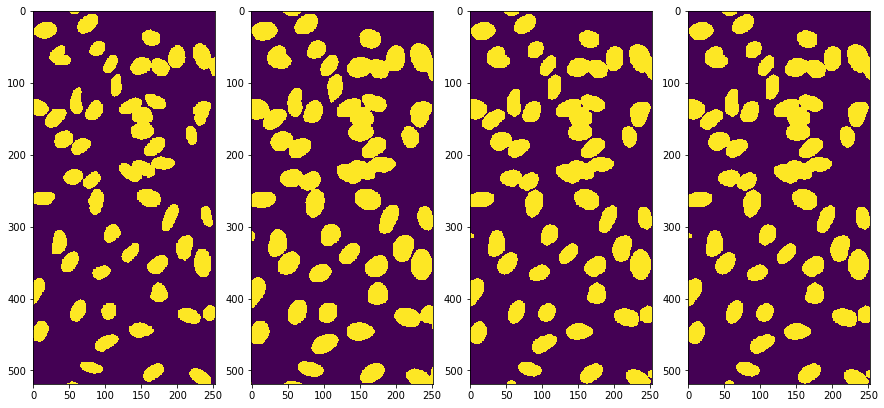

21
18
20


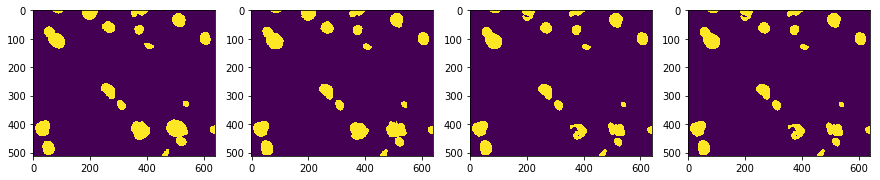

8
11
8


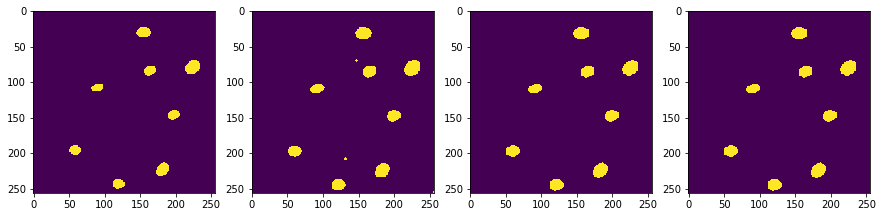

21
16
109


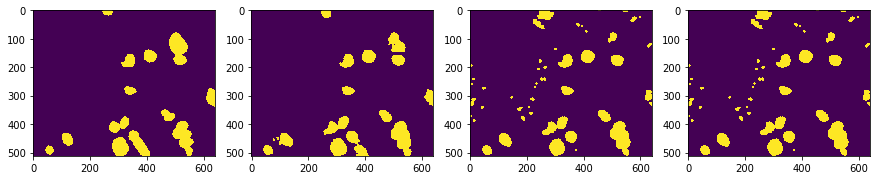

11
23
196


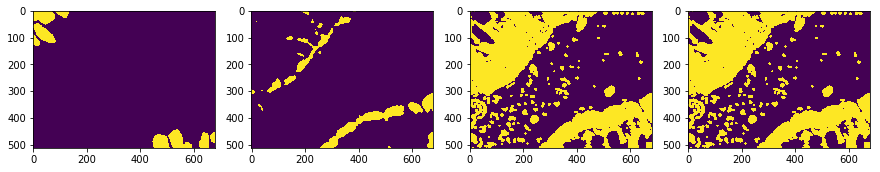

In [55]:
for i in tqdm_notebook(range(len(ids_list[:]))):
    im_id = ids_list[i]
    id_mask = true_masks.ImageId == im_id
    shape = [true_masks[id_mask].iloc[0].Height, true_masks[id_mask].iloc[0].Width]

    true_mask = restore_mask(im_id, shape, true_masks)
    flip_mask = restore_mask(im_id, shape, flip_masks)
    #random_mask = restore_mask(im_id, shape, random_masks)
    #random_mask = cv2.morphologyEx(random_mask, cv2.MORPH_CLOSE, np.ones((2,2)))
    cool_mask = (restore_mask(im_id, shape, cool_masks) > 0.5).astype(int)
    #prec_1.append(calculate_average_precision([x for x in prob_to_masks(true_mask)], [y for y in prob_to_masks(flip_mask)]))
    if True:
#        flip_p[i] = calculate_average_precision([x for x in prob_to_masks(true_mask)], [y for y in prob_to_masks(flip_mask)])
#        random_p[i] = calculate_average_precision([x for x in prob_to_masks(true_mask)], [y for y in prob_to_masks(random_mask)])
        cool_p[i] = calculate_average_precision([x for x in prob_to_masks(true_mask)], [y for y in prob_to_masks(cool_mask)])

#        print(flip_p[i], random_p[i], cool_p[i])

    f, (a1, a2, a3, a4) = plt.subplots(1, 4, figsize=(15,18))
    a1.imshow(true_mask, label='true')
    a2.imshow(flip_mask)
    a3.imshow(cool_mask)
    a4.imshow(cool_mask, label='true')
    plt.legend()
    plt.show()

In [31]:
flip_p.mean()

0.3075034440098649

In [56]:
cool_p.mean()

0.2640391896292031

In [416]:
sum(prec) / len(prec)

0.08592174299753891

In [412]:
calculate_average_precision([x for x in prob_to_masks(true_mask)], [y for y in prob_to_masks(random_mask)])

0.14508379676650243

In [29]:
def iou_at_thresholds(target_mask, pred_mask, thresholds=np.arange(0.5,1,0.05)):
    '''Returns True if IoU is greater than the thresholds.'''
    intersection = np.logical_and(target_mask, pred_mask)
    union = np.logical_or(target_mask, pred_mask)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou > thresholds

def calculate_average_precision(target_masks, pred_masks, thresholds=np.arange(0.5,1,0.05)):
    '''Calculates the average precision over a range of thresholds for one observation (with a single class).'''
    iou_tensor = np.zeros([len(thresholds), len(pred_masks), len(target_masks)])

    for i, p_mask in (enumerate(pred_masks)):
        for j, t_mask in enumerate(target_masks):
            iou_tensor[:, i, j] = iou_at_thresholds(t_mask, p_mask, thresholds)

    TP = np.sum((np.sum(iou_tensor, axis=2) == 1), axis=1)
    FP = np.sum((np.sum(iou_tensor, axis=1) == 0), axis=1)
    FN = np.sum((np.sum(iou_tensor, axis=2) == 0), axis=1)

    precision = TP / (TP + FP + FN)

    return np.mean(precision)

In [30]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)
        
def prob_to_masks(x, cut_off = 0.5, close_size = 1):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        curr = (lab_img==i).astype('uint8')
        circle = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(close_size,close_size))
        yield cv2.morphologyEx(curr.copy(), cv2.MORPH_OPEN, circle)
        #yield (lab_img==i).astype('uint8')

In [371]:
cool_masks[id_mask]

/home/anton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,ImageId,EncodedPixels


In [358]:
plt.subplots(2, 2, figsize=(15,18))

(<matplotlib.figure.Figure at 0x7f985716e198>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f985716e940>,
       dtype=object))

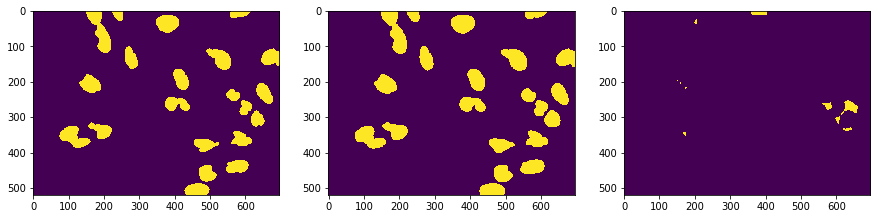

In [199]:
f, (a1, a2, a3) = plt.subplots(1, 3, figsize=(15,18))
a1.imshow(true_mask)
a2.imshow(flip_mask)
a3.imshow(random_mask)
plt.show()

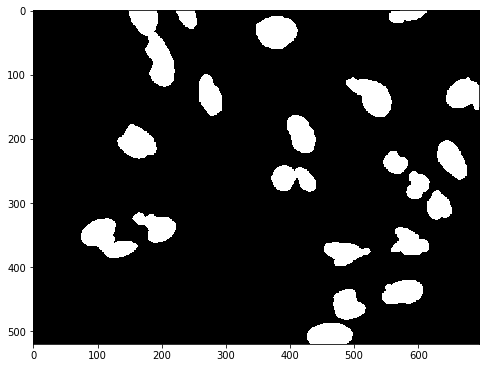

In [186]:
show(true_mask, figsize=(8,8))

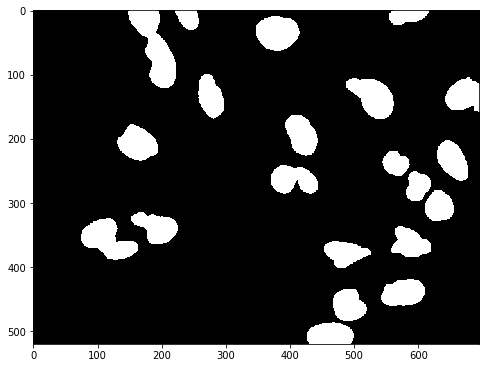

In [188]:
show(flip_mask, figsize=(8,8))

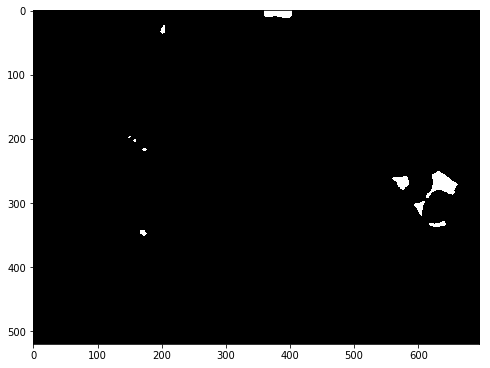

In [187]:
show(random_mask, figsize=(8,8))

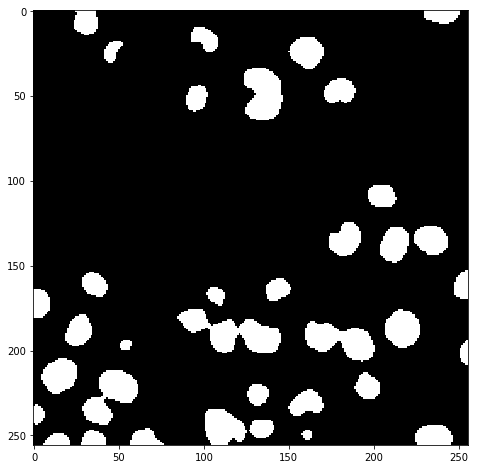

In [179]:
circle5=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
m_open = cv2.morphologyEx(random_mask, cv2.MORPH_CLOSE, circle5)
label(m_open)
show(m_open, figsize=(8,8))

In [180]:
label(m_open).max()

36

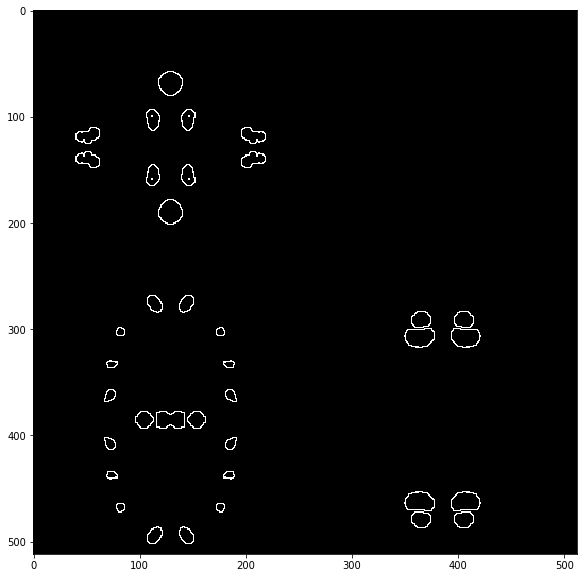

In [110]:
#plt.imshow(train_ims[1], cmap='gray')
#plt.show()
plt.figure(figsize=(10,10))
im = cv2.morphologyEx(train_masks[1], cv2.MORPH_GRADIENT, np.ones((2,2)))
plt.imshow(im, cmap='gray')
plt.show()

In [35]:
del train_masks

In [ ]:
min_horizontal = min([x.shape[1] for x in train_ims])
min_horizontal

In [ ]:
train_ims = [x[:,]]

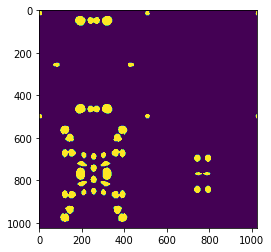

In [123]:
plt.imshow(miror(mask,mask)[0])
plt.show()

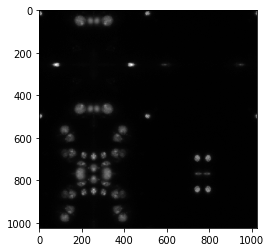

In [124]:
plt.imshow(miror(im,mask)[0], cmap='gray')
plt.show()

## 

In [5]:
shapes = np.zeros((670,3))

for i in range(len(names)):
    im = plt.imread(path + names[i] + "/images/" + names[i] + ".png")
    shapes[i] = im.shape

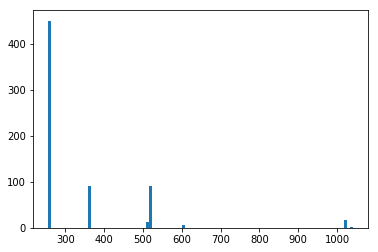

In [6]:
plt.hist(shapes[:,0], bins = 100)
plt.show()

In [22]:
set(shapes[:,0])

{256.0, 260.0, 360.0, 512.0, 520.0, 603.0, 1024.0, 1040.0}

In [19]:
set(shapes[:,1])

{256.0, 320.0, 347.0, 360.0, 640.0, 696.0, 1024.0, 1272.0, 1388.0}

In [38]:
np.where(shapes[:,0] == 1024)

(array([  3,  84,  96, 116, 119, 130, 209, 379, 386, 396, 415, 507, 515,
        617, 666, 667]),)

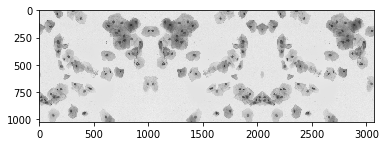

In [39]:
n = 3
im = plt.imread(path + names[n] + "/images/" + names[n] + ".png")
plt.imshow(np.hstack((im[:,::-1,:], im, im[:,::-1,:])))
plt.show()

In [40]:
im.shape

(1024, 1024, 4)

In [13]:
def random_select(im, mask, shape = (256, 256)):
    x = np.random.randint(0, im.shape[0] - shape[0])
    y = np.random.randint(0, im.shape[1] - shape[1])
    
    excerpt_x = slice(x, x+shape[0])
    excerpt_y = slice(y, y+shape[1])
    
    return im[excerpt_x, excerpt_y, :], mask[excerpt_x, excerpt_y, :]

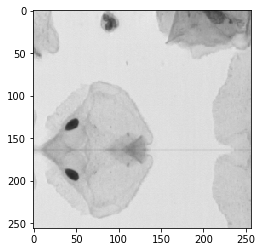

In [14]:

plt.imshow(random_select(miror(im, im)[0], miror(im, im)[0])[0])
plt.show()

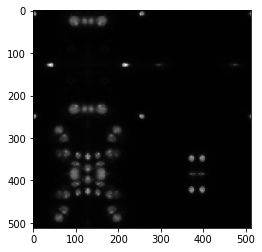

In [24]:
im = train_ims[0]
plt.imshow(im, cmap='gray')
plt.show()

In [15]:
import Augmentor as au

In [17]:
p = au.Pipeline()#.(miror(im, im)[0])

p.rotate(1, 25, 25)
p.flip_random(1)
p.random_distortion(1, 10,10,8)
p.skew(1)
p.

In [33]:
np.expand_dims(np.expand_dims(im, 0),3).shape

(1, 512, 512, 1)

In [79]:
im_w_mask = np.stack((train_ims[0], train_masks[0]), 2)
g = p.keras_generator_from_array((np.expand_dims(im_w_mask, 0)*255).astype('uint8'),np.ones(1), 1, )

In [78]:
#gens = [p.keras_generator_from_array(np.expand_dims(im, 0)*255).astype('uint8'),np.ones(1), for im in train_ims]

SyntaxError: invalid syntax (<ipython-input-78-5394cedf5a4b>, line 1)

In [ ]:
cv2.

In [90]:
n = next(g)

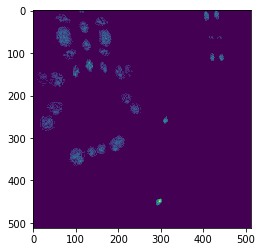

In [91]:
#augm_im = next(g)[0]
plt.imshow(n[0][0][:,:,0])
plt.show()

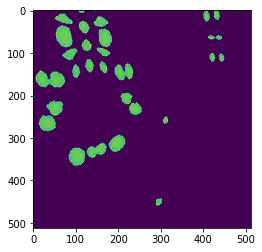

In [92]:
plt.imshow(n[0][0][:,:,1])
plt.show()

In [135]:
augm_im.shape

(1, 3072, 3072, 4)

In [77]:
np.expand_dims(miror(im, im)[0], 0).shape

(1, 3072, 3072, 4)

## ANSW

In [1]:
from skimage.morphology import label # label regions
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

In [7]:
a = np.zeros((4,4))
a[0,1],a[1,1], a[1,2], a[2,1] = 1,1,1,1
a

array([[0., 1., 0., 0.],
       [0., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [8]:
rle_encoding(a)

[5, 3, 10, 1]

In [17]:
b = np.vstack((a,a))

In [10]:
[x for x in prob_to_rles(np.vstack((a,a)))]

[[9, 3, 18, 1], [13, 3, 22, 1]]